# 决策分析

## “正确的价格”问题

1. 在看到奖品前，选手对展示品的价格应该有什么样的先验分布判断？
2. 看到奖品后，选手应该如何修正这些预期？
3. 基于后验分布，选手应该怎么出价？（决策分析）

PDF 概率密度函数  
KDE 内核密度估计，从样本找到一个恰当平滑的PDF进行数据拟合

In [84]:
from thinkbayes import EstimatedPdf, MakeCdfFromList, GaussianPdf
import numpy as np
from tools import ReadData

In [85]:
from thinkbayes import Suite
class Price(Suite):
    def __init__(self, pmf, player, name=''):
        Suite.__init__(self, pmf, name=name)
        self.player = player
        
    def Likelihood(self, data, hypo):
        price = hypo # 历史数据中统计的价格
        guess = data # 选手猜测的价格
        
        error = price - guess
        like = self.player.ErrorDensity(error)
        return like

In [86]:
class Player(object):
    n = 101
    price_xs = np.linspace(0, 75000, n)
    
    def __init__(self, prices, bids, diffs):
        # KDE 内核密度估计
        self.pdf_price = EstimatedPdf(prices)
        # 出价差的累计分布
        self.cdf_diff = MakeCdfFromList(diffs)
        
        # 假设error的分布是一个和diff方差相同，均值为0的高斯分布
        mu = 0
        sigma = np.std(diffs)
        self.pdf_error = GaussianPdf(mu, sigma)
        
    def PmfPrice(self):
        # 转换成概率质量函数
        return self.pdf_price.MakePmf(self.price_xs)
    
    def MakeBeliefs(self, guess):
        pmf = self.PmfPrice()
        self.prior = Price(pmf, self, name='prior')
        self.posterior = self.prior.Copy(name='posterior')
        self.posterior.Update(guess)
        
    def ErrorDensity(self, error):
        return self.pdf_error.Density(error)
    
    def ProbOverbid(self):
        # 选手预测超过实际价格的概率
        return self.cdf_diff.Prob(-1)
    
    def ProbWorseThan(self, diff):
        return 1 - self.cdf_diff.Prob(diff)

In [87]:
def MakePlayers():
    data = ReadData('./data/showcases.2011.csv')
    data += ReadData('./data/showcases.2012.csv')
    cols = zip(*data)
    # 实际价格， 猜测价格， 误差
    price1, price2, bid1, bid2, diff1, diff2 = cols
    
    player1 = Player(price1, bid1, diff1)
    player2 = Player(price2, bid2, diff2)
    
    return player1, player2

In [88]:
guess1 = 20000
guess2 = 40000
# 将选手作为一种误差特性已知的价格猜测仪来建模
player1, player2 = MakePlayers()

# 我们把之前的历史数据当做先验概率，然后基于你的猜测去修正它
player1.MakeBeliefs(guess1)
player2.MakeBeliefs(guess2)

对于Player1，如果你认为价格是20000美元，那么在考虑猜测误差的情况下，你应该相信价格是24000美元。

In [89]:
print('Player 1 prior mle', player1.prior.MaximumLikelihood())
print('Player 2 prior mle', player2.prior.MaximumLikelihood())
print('Player 1 mean', player1.posterior.Mean())
print('Player 2 mean', player2.posterior.Mean())
print('Player 1 mle', player1.posterior.MaximumLikelihood())
print('Player 2 mle', player2.posterior.MaximumLikelihood())

('Player 1 prior mle', 27750.0)
('Player 2 prior mle', 27750.0)
('Player 1 mean', 25096.411816206248)
('Player 2 mean', 35641.216869713542)
('Player 1 mle', 24000.0)
('Player 2 mle', 35250.0)


## 最优出价

In [90]:
class GainCalculator(object):
    # 计算最优报价
    def __init__(self, player, opponent):
        self.player = player
        self.opponent = opponent
        
    # 为每次出价计算投标序列和预期收益
    def ExpectedGains(self, low=0, high=75000, n=101):
        bids = np.linspace(low, high, n)
        # bid是选手可能的出价
        gains = [self.ExpectedGain(bid) for bid in bids]
        
        return bids, gains
    
    # 计算对于一个给定的报价的预期值
    def ExpectedGain(self, bid):
        suite = self.player.posterior
        # 此时的后验即可看做商品真实的价格
        total = 0
        for price, prob in sorted(suite.Items()):
            gain = self.Gain(bid, price)
            total += prob * gain
        return total
            
    def Gain(self, bid, price):
        if bid > price:
            return 0
        
        diff = price - bid
        prob = self.ProbWin(diff)
        
        if diff <= 250:
            return 2 * price * prob
        else:
            return price * prob
        
    def ProbWin(self, diff):
        prob = (self.opponent.ProbOverbid() +
                self.opponent.ProbWorseThan(diff))
        return prob

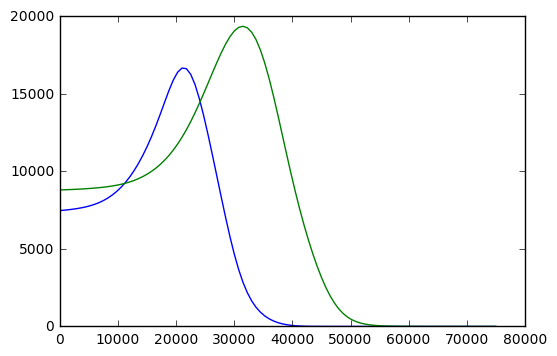

In [94]:
calc1 = GainCalculator(player1, player2)
calc2 = GainCalculator(player2, player1)
bids1, gains1 = calc1.ExpectedGains()
bids2, gains2 = calc2.ExpectedGains()
import matplotlib.pyplot as plt
plt.plot(bids1, gains1, bids2, gains2)
plt.show()